# Simulation

In [1]:
import pickle
import numpy as np
import pandas as pd
from numpy.random import default_rng
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import os
os.environ["OMP_NUM_THREADS"] = '1'  # To avoid KMeans memory leak from sklearn 

from IPython.display import clear_output
from functions import one_hot
from DeepLPTM.ETM_raw.scripts.data_preprocessing import *
from DeepLPTM.Simulations import Simulation_BBC
from IPython.display import clear_output
rng = default_rng(seed = 2)

In [2]:
import os
#from Simulations_BBC import Simulation_BBC
from ETM_raw.scripts.data_preprocessing import preprocessing
np.set_printoptions(precision=2)

# To begin with
#SIMULATIONS_root = 'Simulations/'
SIMULATIONS_root = r"C:\Users\remib\Documents\2022\deeplptm_package_nips\Simulations"
BBC_root         = os.path.join(SIMULATIONS_root, 'bbc')

difficulty           = 'Easy'
scenario             = 'ScenarioC'
simulate_new_dataset = True
N                    = 100

if simulate_new_dataset:
    # Not working properly. Different results than with R dataset with the same parameters. To investigate.
    simu_path        = os.path.join(BBC_root, scenario)
    Q, K, A, T, W, pi, node_cluster, topics = Simulation_BBC(
        BBC_root=BBC_root, 
        save_path=simu_path,
        N=N,
        scenario=scenario,
        difficulty=difficulty,
        verbose=True
    )
    topics = T[A != 0]
else:
    simu_path        = os.path.join(BBC_root, scenario, '1/')
    A                = pd.read_csv(os.path.join(simu_path, 'adjacency.csv'),
                           index_col=None, header=None, sep=';').to_numpy()
    node_cluster     = pd.read_csv(os.path.join(simu_path, 'clusters.csv'),
                           index_col=None, header=None,sep=';').to_numpy().squeeze() - 1
    W                = pd.read_csv(os.path.join(simu_path, 'texts.csv'),
                           index_col=None, header=None, sep='/').to_numpy()
    T                = pd.read_csv(os.path.join(simu_path, 'topics.csv'),
                           index_col=None, header=None, sep=';').to_numpy()
    
    topics   = T[A != 0] - 1
    K        = np.unique(topics).shape[0]
    Q        = np.unique(node_cluster).shape[0]
    W        = W[A != 0].tolist()
    #args.hidden2_dim = 3
    N = A.shape[0]
    M = A.sum()
    
# Preprocess the texts using ETM preprocessing tools
etm_path = os.path.join(simu_path, 'etm/')
  

Cluster proportion [0.32 0.29 0.19 0.2 ]
Connection probabilities :
 [[0.25 0.01 0.01 0.01]
 [0.01 0.25 0.01 0.01]
 [0.01 0.01 0.25 0.25]
 [0.01 0.01 0.25 0.25]]
Topics between clusters :
 [[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 2.]]
The proportions of connection between clusters in the dataset is :
[[0.22 0.01 0.   0.01]
 [0.02 0.24 0.01 0.01]
 [0.01 0.01 0.25 0.25]
 [0.01 0.02 0.24 0.23]]


# Representation of the data

C:\Users\remib\Anaconda3\envs\GCN\lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


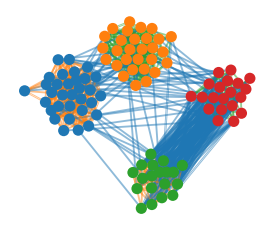

In [3]:
import networkx as nx
from netgraph import Graph
import matplotlib.pyplot as plt
G = nx.DiGraph()
edges = np.where(A)
for (i, j) in zip(edges[0].tolist(), edges[1].tolist()):
    G.add_edge(i, j)
    
    
community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
}

node_to_cluster = {node: node_cluster[node] for node in G.nodes}
edge_to_topic   = {(i,j):T[i,j] for (i,j) in zip(edges[0], edges[1])}

node_color = {node: community_to_color[cluster] for node, cluster in node_to_cluster.items()}
edge_color = {edge: community_to_color[topic] for edge, topic in edge_to_topic.items()}

Graph(G,
      node_color=node_color, node_edge_width=0, edge_alpha=0.5, edge_color = edge_color,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_cluster))
plt.show()


In [4]:
preprocessing(W, path_save=etm_path, max_df=1., min_df=1, prop_Tr=1, vaSize = 0)

reading data...
counting document frequency of words...
building the vocabulary...
  initial vocabulary size: 796
  vocabulary size after removing stopwords from list: 592
Vocabulary size: 592
Data ready !!
*************


C:\Users\remib\Anaconda3\envs\GCN\lib\site-packages\scipy\io\matlab\_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


In [5]:
assert int(A.sum()) == len(W), 'The number of texts and edges is different. A simulation problem occured'

# Initialise ETM and Deep-LPM
If the models are not initialised, it might be more difficult to recover the true partition. In addition, the running time would be much more important to obtain interesting node positions. 

## ETM initialisation

In [6]:
from ETM_raw.main import ETM_algo
import torch
from ETM_raw.data import get_batch
from sklearn.metrics import adjusted_rand_score as ARI

use_pretrained_emb = False
etm_init_epochs    = 60
seed               = 0 

etm = ETM_algo(data_path= etm_path,
               dataset='BBC',
               seed=seed,
               enc_drop=0,
               train_embeddings=True,
               use_pretrained_emb=use_pretrained_emb,
               emb_path=None,
               save_path=etm_path,
               batch_size=30,
               epochs=etm_init_epochs,
               num_topics=K)

etm.model.float()
etm.train_etm()
DTM = get_batch(etm.train_tokens, etm.train_counts, range(etm.train_tokens.shape[0]), len(etm.vocab), device='cuda')
DTM_norm = DTM / DTM.sum(1,keepdims=True)

theta, _ = etm.model.get_theta(DTM_norm)
theta    = theta.detach().cpu().numpy()
clear_output()

print('Documents ARI : {}'.format(ARI(topics, theta.argmax(-1))))        
torch.save(etm, os.path.join(etm_path, 'etm_init_pretrained_{}.pt'.format(int(use_pretrained_emb))))

Documents ARI : 1.0


## Deep-LPM initialisation

In [7]:
from os.path import join
from DeepLPTM.functions import DeepLPM_format
from DeepLPTM.deepLPM_main import model as Model
from DeepLPTM import args
from DeepLPTM.model import training_graph_vectorization
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

M = int(A.sum())
P = 2
N = int(A.shape[0])

"""
adj = np.load(join(simu_path, 'adjacency.npy'))
clusters = np.load(join(simu_path, 'clusters.npy'))

args.P = 2
args.K = K
args.num_clusters = Q
args.device = device
args.num_points= A.shape[0]
args.num_edges = int(A.sum())
"""


#args.K = K
args.P = 2
args.hidden2_dim = P
#args.M = M
#args.N = N
#args.Q = Q
args.num_clusters = Q
args.num_points   = N
args.K            = K
args.num_edges    = M
args.device       = device
adj, adj_label, adj_norm, features, edges, indices = DeepLPM_format(A, args)
args.indices = indices

deepLPM = getattr(Model, args.model)(adj_norm)
deepLPM.to(device)  # to GPU
deepLPM.pretrain(features, adj_label, edges, verbose=False)  # pretraining
optimizer = Adam(deepLPM.parameters(), lr=args.learning_rate)  # , weight_decay=0.01
deepLPM = deepLPM.to(device)

print('DeepLPM ARI : {}'.format(ARI(deepLPM.gamma.argmax(-1).detach().cpu().numpy(),
                                    node_cluster)))

ModuleNotFoundError: No module named 'deepLPTM'

In [8]:
from DeepLPTM import args

In [ ]:
deepLPM.log_cov_k

# Deep-LPTM training

In [16]:
results = training_graph_vectorization(adj_label,
                                       features,
                                       edges,
                                       optimizer,
                                       etm,
                                       deepLPM,
                                       args,
                                       labels=node_cluster,
                                       topics=T[A!=0],
                                       epochs=50,
                                       tol=1e-3,
                                       adj=A,
                                       ratio=False,
                                       use='all',
                                       init='dissimilarity', 
                                       init_path=None,
                                       full_batch = False,
                                       device=None)

ARI of initialisation : 1.00


IndexError: index 3 is out of bounds for dimension 0 with size 3

# Results
First, we ensure that the ELBO increased during the training.

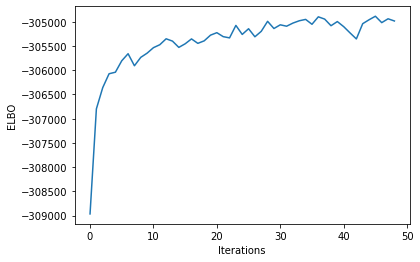

In [21]:
import matplotlib.pyplot as plt

plt.plot(results['elbo'])
plt.ylabel('ELBO')
plt.xlabel('Iterations')
plt.show()

Second, we plot the representation of the network with the information gathered by DeepLPTM, regarding the nodes and the edges.

In [29]:
clusters_dlptm = {node: results['tau'].argmax(-1)[node] for node in G.nodes}
node_positions = { node: (results['mu_X'][node, 0], results['mu_X'][node, 1]) for node in G.nodes}
node_colors    = { node: community_to_color[clusters_dlptm[node]] for node in G.nodes}

T_dlptm        = np.copy(T)
T_dlptm[A != 0]= results['theta'].argmax(-1)
topics_dlptm   = {(i,j): T_dlptm[i, j] for (i,j) in G.edges}
edge_colors   = { (i,j): community_to_color[topics_dlptm[(i,j)]] for (i,j) in G.edges}

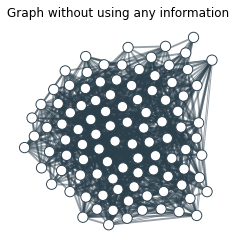

In [40]:
Graph(G)
plt.title('Graph without using any information')
plt.show()

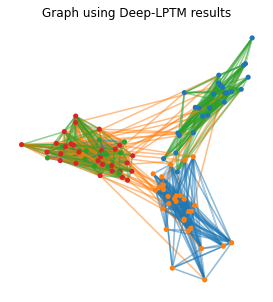

In [41]:
node_color = {node: community_to_color[cluster] for node, cluster in node_to_cluster.items()}

plt.figure(figsize=(5,5))
Graph(G, 
      node_layout=node_positions,
      node_color= node_colors, 
      edge_color = edge_colors,
      node_size = 5,
      node_edge_width=0,
      edge_alpha=0.5,
      edge_width=3)
plt.title('Graph using Deep-LPTM results')
plt.show()